# Classify Filament Dynamics using quantitative metrics

In [168]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate

import os
import pyfilaments.analysisutils as analysis
import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

In [169]:

# Load the data
# Updated simulation data (no discretization errors)
root_folder = '/media/deepak/DEEPAK-1TB/ActiveFilaments_Simulations_Backup_1/BendingStiffnessSweeps/b0_2_1_FullSweep_Final/activity_time_750'

# Periodic example (same period as forcing)
# track_folder = 'SimResults_Np_32_Shape_line_kappa_hat_4.0_k_15.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point'

# Periodic example (period doubling)
track_folder = 'SimResults_Np_32_Shape_line_kappa_hat_6.0_k_22.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point'

# Periodic example (period quadrupling)
# track_folder = 'SimResults_Np_32_Shape_line_kappa_hat_8.0_k_30.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point'

# Aperiodic example
# track_folder = 'SimResults_Np_32_Shape_line_kappa_hat_6.0_k_25.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point'


file = 'SimResults_01.hdf5'

folder, *rest = os.path.split(os.path.join(root_folder, track_folder, file))

print(folder)

filament = analysis.analysisTools(file = os.path.join(root_folder, track_folder, file))

file_path = filament.analysis_folder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

/media/deepak/DEEPAK-1TB/ActiveFilaments_Simulations_Backup_1/BendingStiffnessSweeps/b0_2_1_FullSweep_Final/activity_time_750/SimResults_Np_32_Shape_line_kappa_hat_6.0_k_22.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile not found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /media/deepak/DEEPAK-1TB/ActiveFilaments_Simulations_Backup_1/BendingStiffnessSweeps/b0_2_1_FullSweep_Final/activity_time_750/SimResults_Np_32_Shape_line_kappa_hat_6.0_k_22.0_b0_2.1_F_0_S_0_D_1.5_activityTime_750_simType_point
Data file SimResults_01.hdf5


## Check for periodic vs aperiodic behavior of the filament

In [159]:
''' Method to detect Periodic vs Aperiodic behavior.
- Compare the subsequent filament shapes at constant phase.
- if the Euclidean distance between shapes goes below a certain value \epsilon
    Classify the dynamics as Periodic
- Else classify the dynamics as Aperiodic (at least over the simulation duration)

'''
# Find time points at a constant phase (stroboscopic)
# In the current activity profile, phase = 0 is start of compression, phase = pi is start of extension
phase_value = np.pi/2

# Smallest phase difference = 2*pi*delta_T/T
delta_phase = 2*np.pi*np.mean(filament.Time[1:]-filament.Time[:-1])/filament.activity_timescale

print(delta_phase)

abs_val_array = np.abs(filament.derived_data['Phase'] - phase_value)

constant_phase_mask = abs_val_array <= 0.5*delta_phase

print(constant_phase_mask)
print(len(constant_phase_mask))
print(len(filament.derived_data['Phase'][constant_phase_mask]))

time_points = np.array(range(0, filament.Nt))
constant_phase_indices = time_points[constant_phase_mask]

0.08377580409572781
[False False False ... False False False]
37501
500


## Detect if dynamics is Periodic/Aperiodic and if periodic find the smallest frequency 

None


<IPython.core.display.Javascript object>


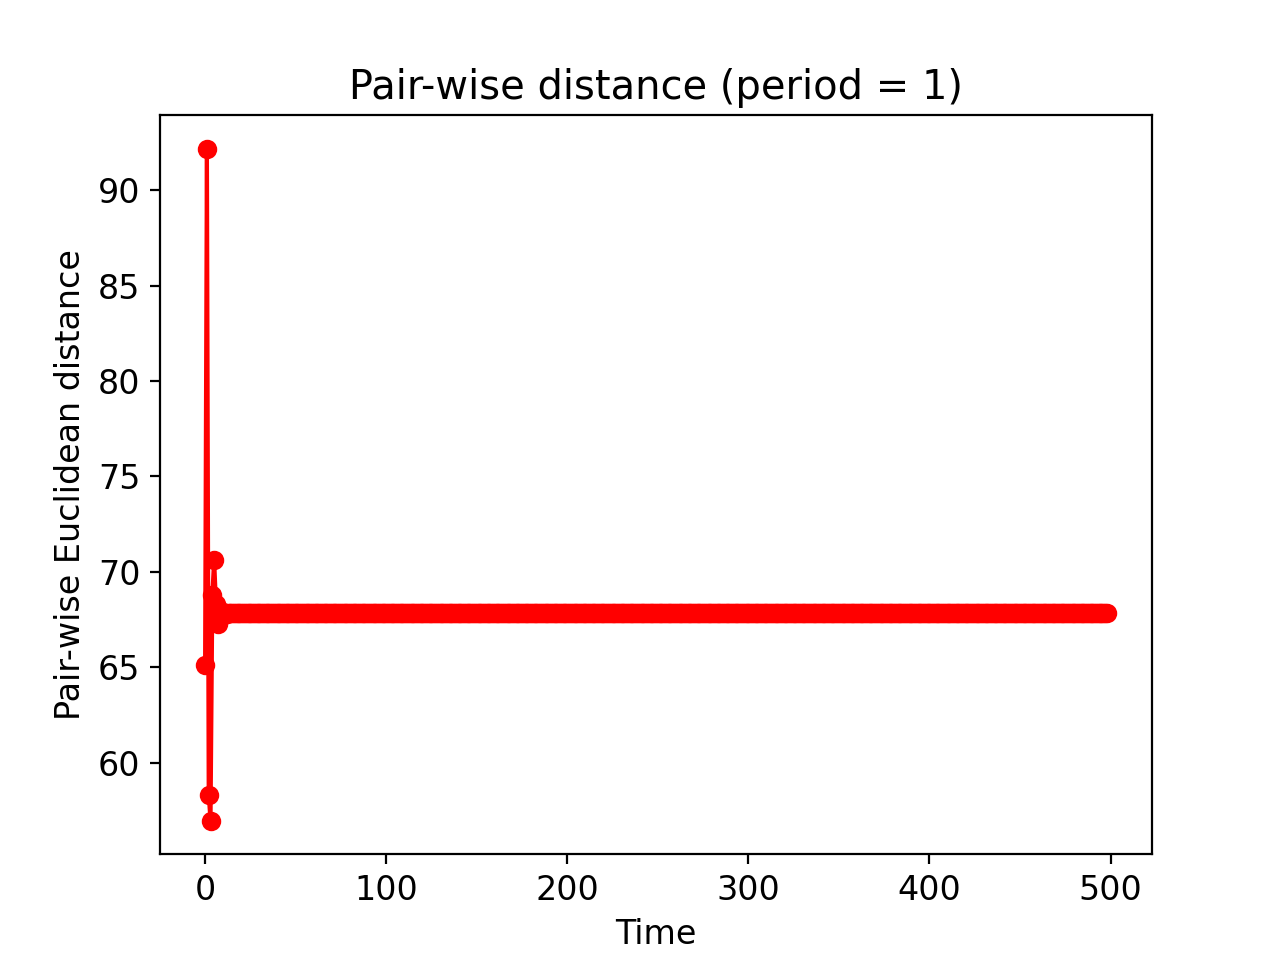

11
Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


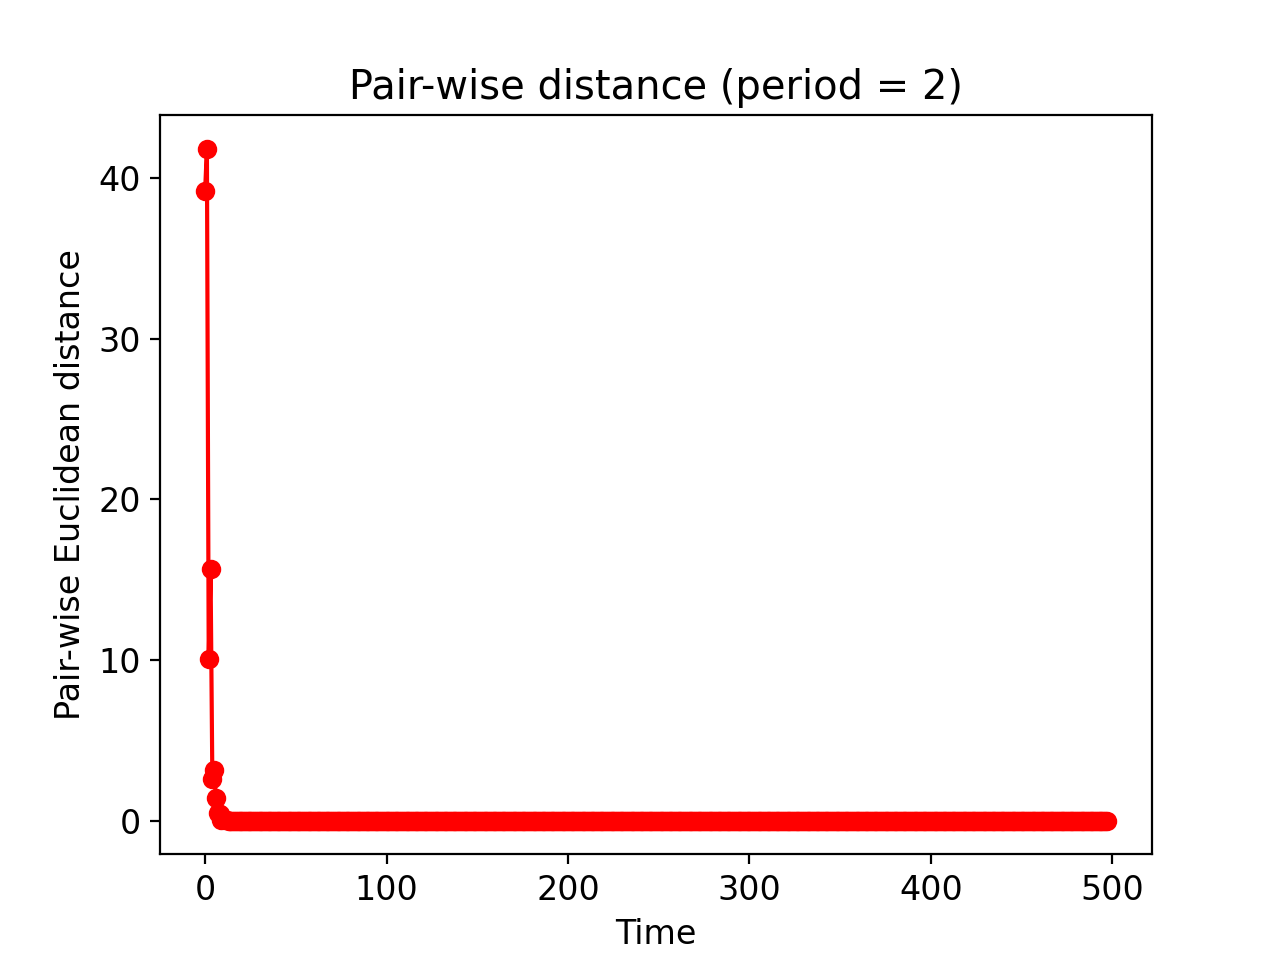

None


<IPython.core.display.Javascript object>


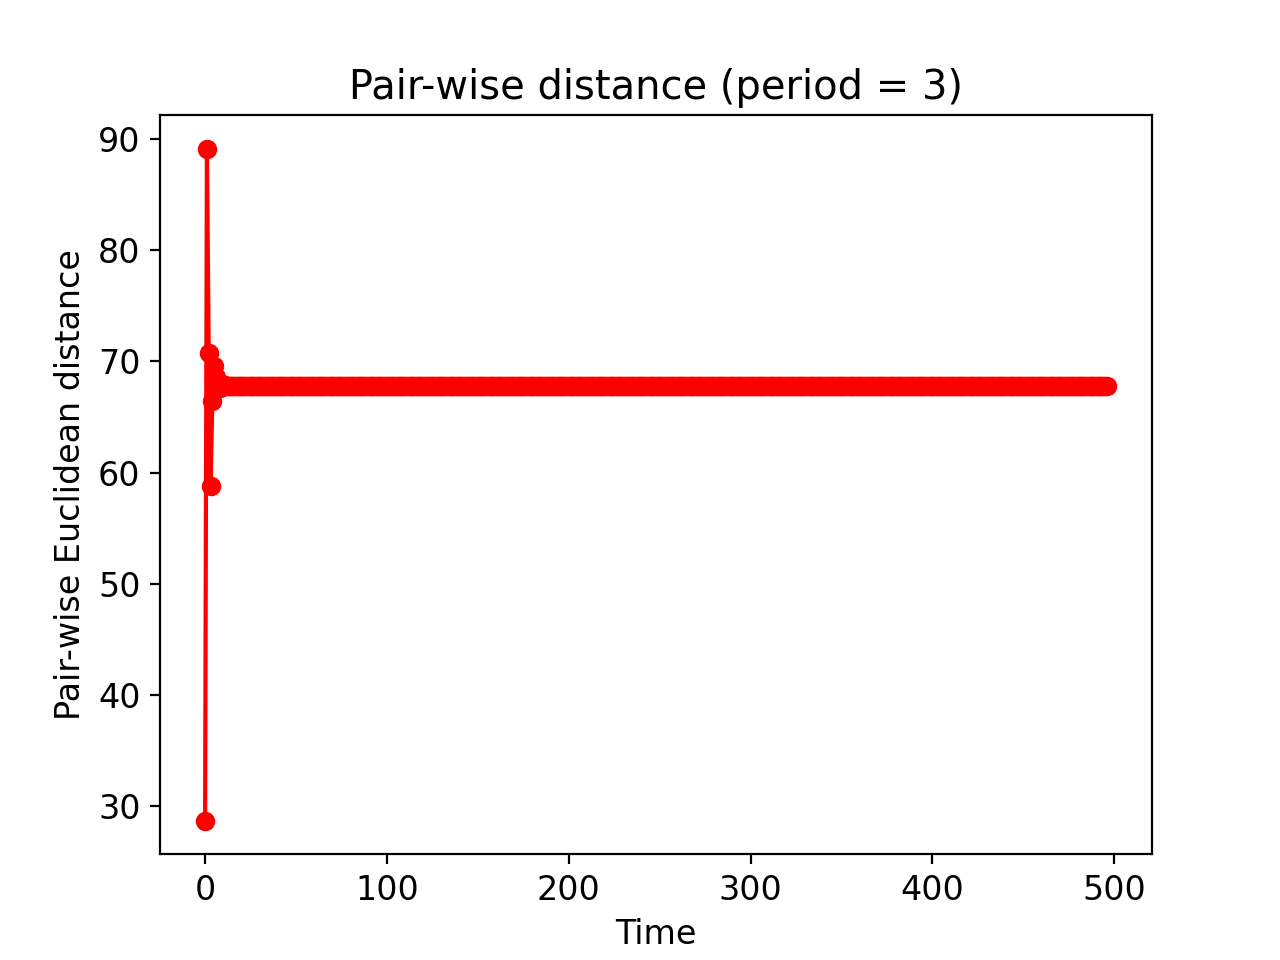

9
Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


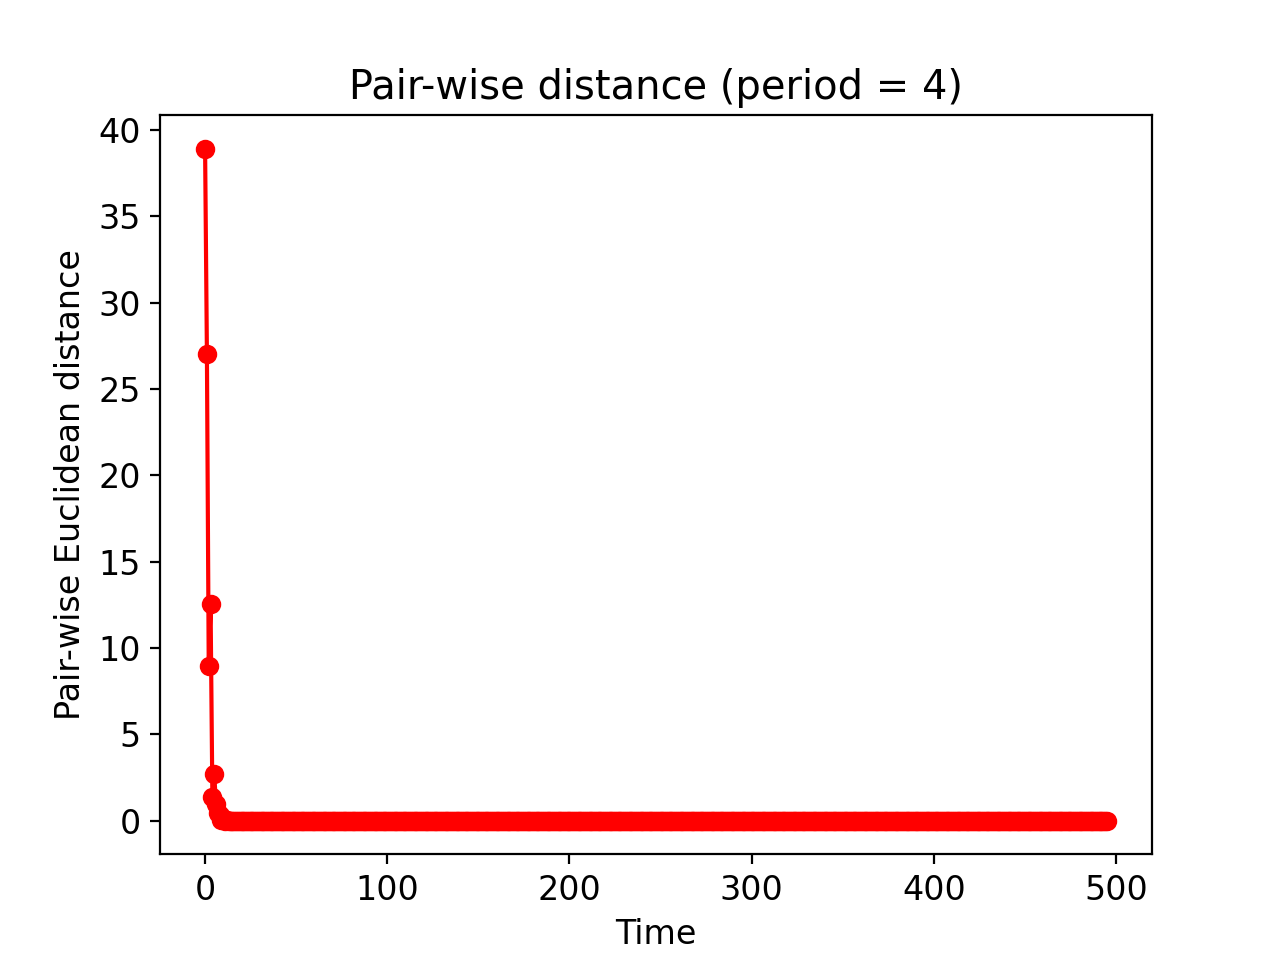

9
Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


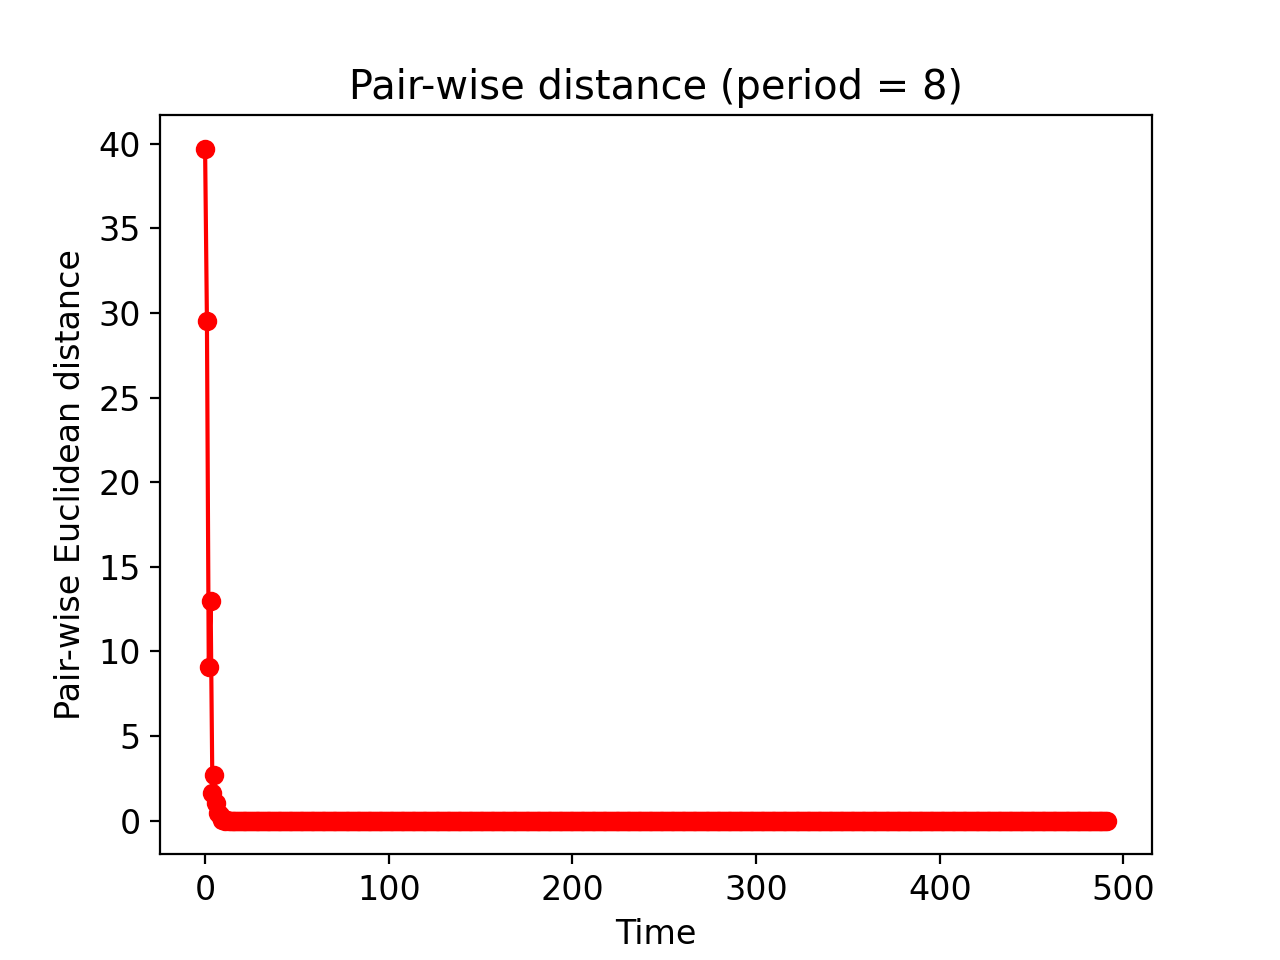

9
Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


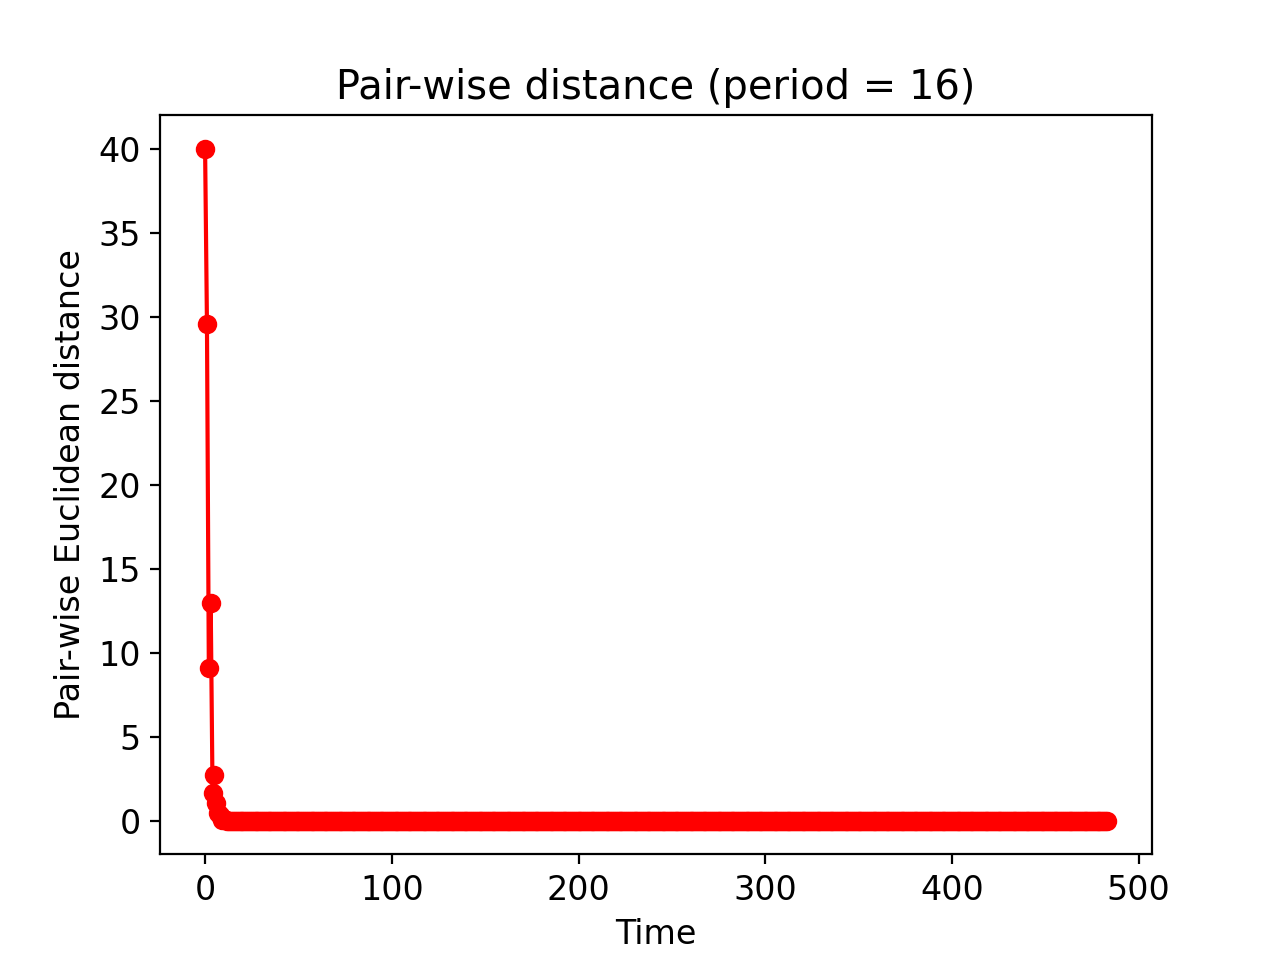

**************************************************
Is the dynamics Periodic? :True
**************************************************
The minimum period of the system is 2 times the forcing period
**************************************************


In [160]:

# Compare filament shapes at two points at constant phase 
periodic_flag = False
period_array = [1, 2, 3, 4, 8, 16] # Number of periods over which we want to compare. period = 1 means every cycle.

below_threshold_array = np.zeros(len(period_array), dtype = 'bool')
# Threshold value for comparing shapes of filaments. Currently choosen as 10% of the sphere radius. 
epsilon = 0.1*filament.radius

for period_index, period in enumerate(period_array):

#     period = 4 
    pair_wise_distance = np.zeros(len(constant_phase_indices)-period)

    for ii in range(len(constant_phase_indices)-period):

        index_a = constant_phase_indices[ii]
        index_b = constant_phase_indices[ii+period]


        filament_a = filament.R[index_a, :]
        filament_b = filament.R[index_b, :]


#         if(ii==0):
#             filament.plotFilament(r = filament_a)
#             filament.plotFilament(r = filament_b)

        # Calculate the pair-wise distance between the shapes of the two filaments
        distance = filament.euclidean_distance(filament_a, filament_b)
        pair_wise_distance[ii] = distance

    # Find if the distance goes below the threshold (and stays there)
    threshold_index = next((i for i,x in enumerate(pair_wise_distance) if pair_wise_distance[i]<=epsilon and np.all(pair_wise_distance[i:]<epsilon)), None)
        
    print(threshold_index)
    if(threshold_index is not None):
        below_threshold_flag = True
        print('Does distance STAY below the threshold?: {}'.format(below_threshold_flag))
        below_threshold_array[period_index] = below_threshold_flag
        periodic_flag = True
        
    # Plot the pairwise distance over time
    plt.figure()
    plt.plot(pair_wise_distance, 'ro-')
    plt.xlabel('Time')
    plt.ylabel('Pair-wise Euclidean distance')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.title('Pair-wise distance (period = {})'.format(period))
    plt.show()
    

# Summarize the results

print(50*'*')
print('Is the dynamics Periodic? :{}'.format(periodic_flag))
min_period = next((x for i, x in enumerate(period_array) if below_threshold_array[i]==True), None)
print(50*'*')
if(min_period is not None):
    print('The minimum period of the system is {} times the forcing period'.format(min_period))
    print(50*'*')

# Frequency domain analysis of Filament time series data

In [125]:
filament.compute_base_tip_angle()
filament.compute_tip_angle()
filament.compute_arc_length()

time_series_data = filament.derived_data['tip angle']
time_series_data = time_series_data - np.mean(time_series_data)

In [126]:
### FFT of the time-series data
from scipy.fft import rfft, rfftfreq

SAMPLE_RATE = filament.Nt/(max(filament.Time))

print('Time series sample rate: {}'.format(SAMPLE_RATE))
yf = rfft(time_series_data)
xf = rfftfreq(filament.Nt, 1 / SAMPLE_RATE)



Time series sample rate: 0.10000266666666667


<IPython.core.display.Javascript object>


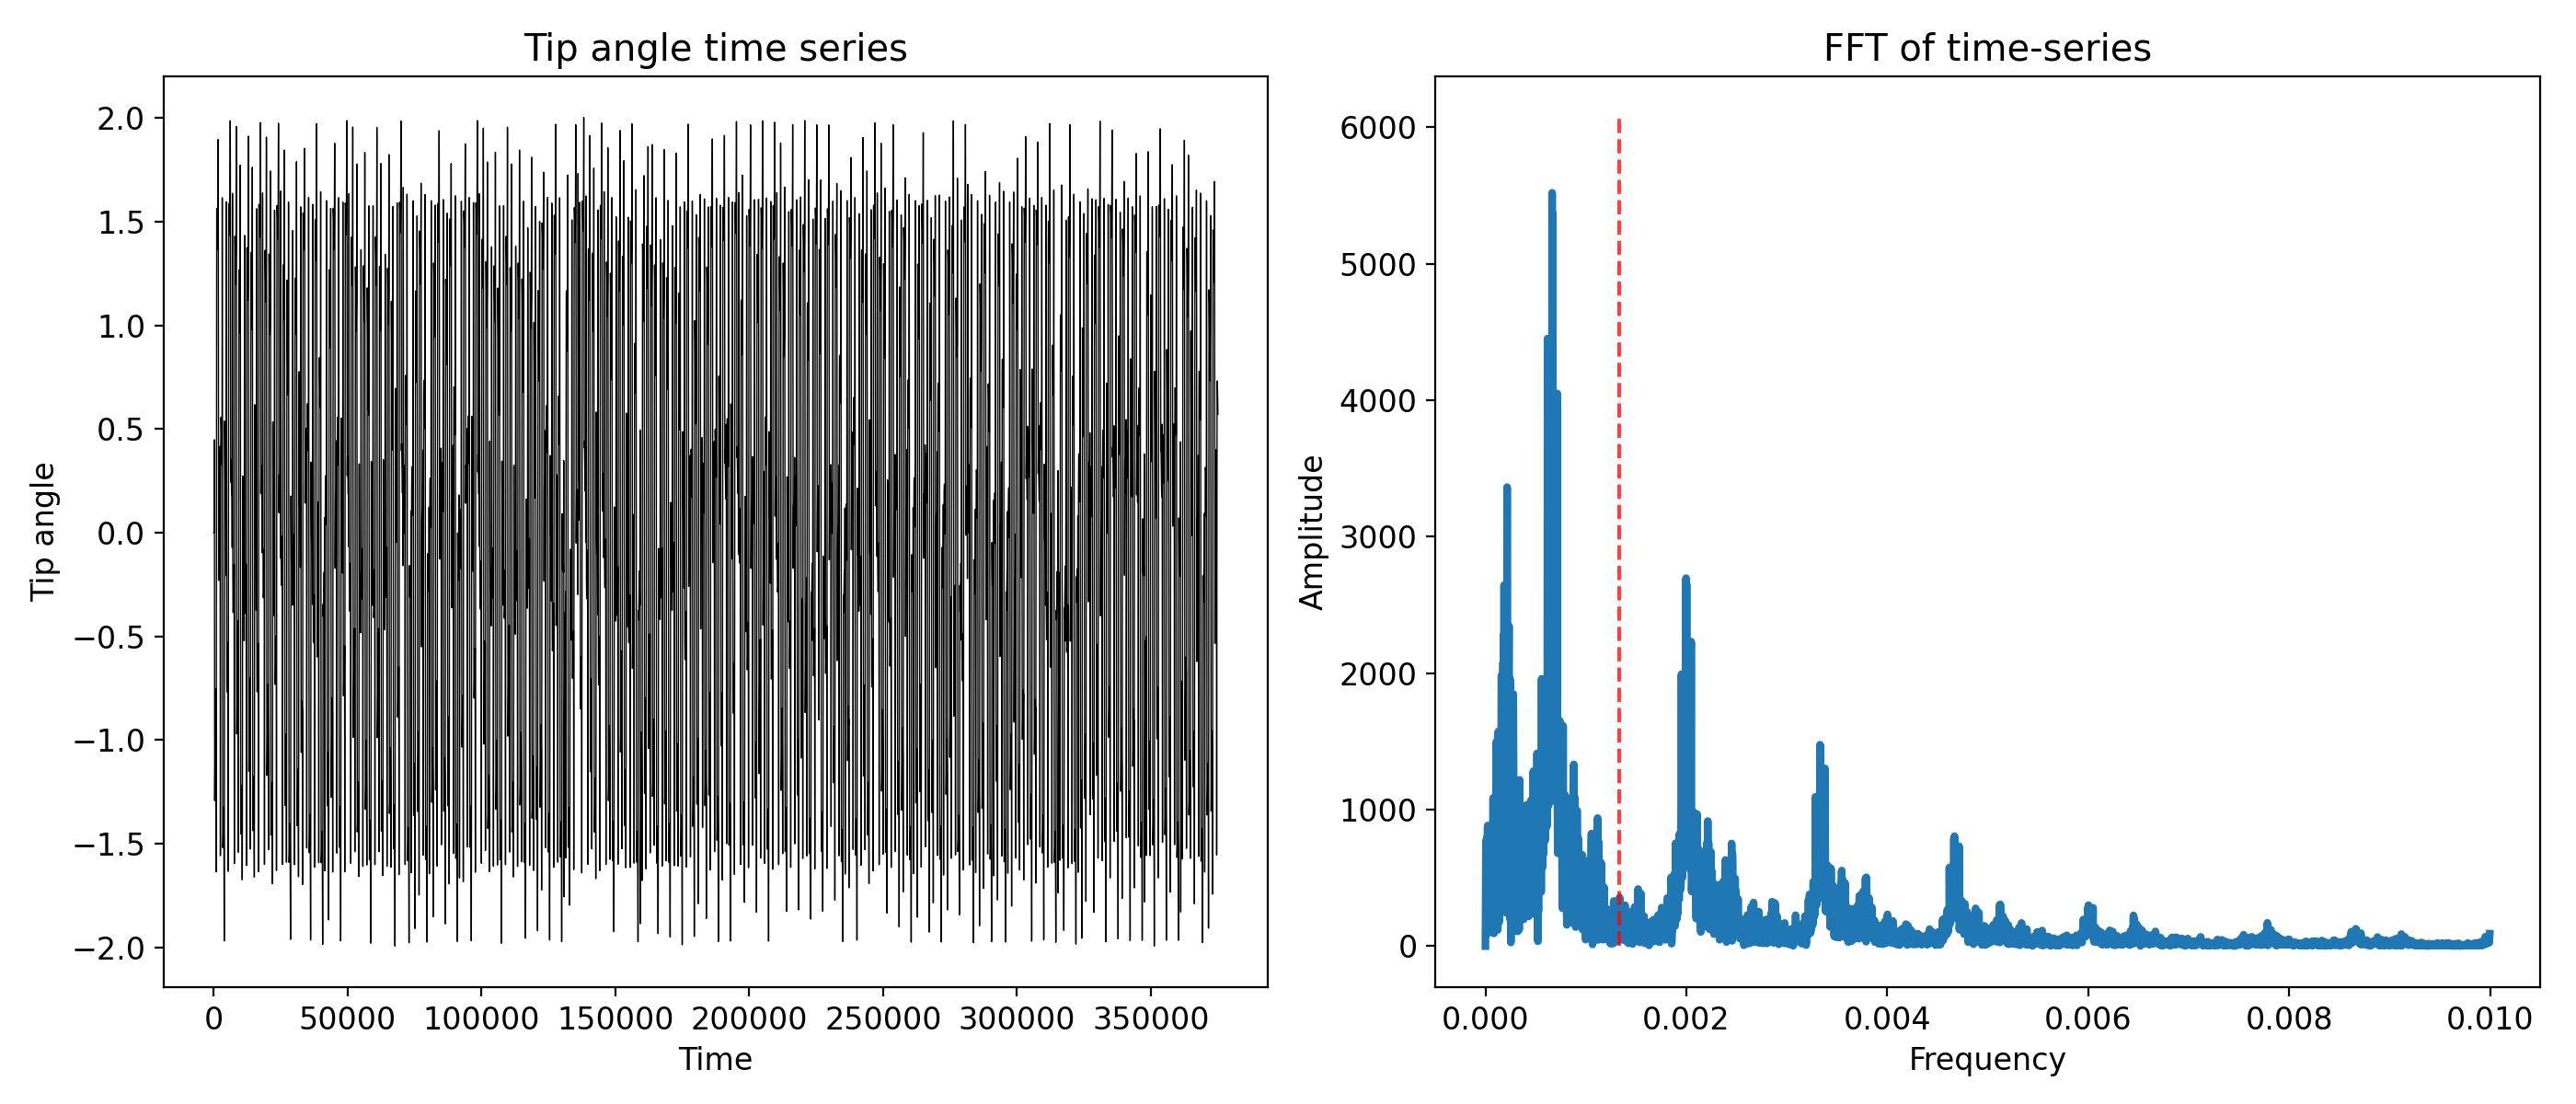

In [127]:
# Plot the FFT of the signal


clip_point = int(len(xf)/5)
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols = 2, figsize = (14, 6))

ax0.plot(filament.Time, filament.derived_data['tip angle'],color = 'k', linewidth = 0.5)
ax0.set_xlabel('Time')
ax0.set_ylabel('Tip angle')
ax0.set_title('Tip angle time series')

ax1.plot(xf[:clip_point], np.abs(yf[:clip_point]), linewidth = 3)
# Draw the forcing frequency
plt.vlines(1/filament.activity_timescale, 0, np.max(np.abs(yf[:clip_point]))+np.max(np.abs(yf[:clip_point]))/10, color = 'r', linestyle = '--',zorder=100, alpha = 0.75)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Amplitude')
ax1.set_title('FFT of time-series')
plt.tight_layout()

# Save the plot
plt.savefig(os.path.join(file_path, 'filament_time_series_fft.png'), dpi = 300)
plt.savefig(os.path.join(file_path, 'filament_time_series_fft.svg'), dpi = 300)

plt.show()

<IPython.core.display.Javascript object>


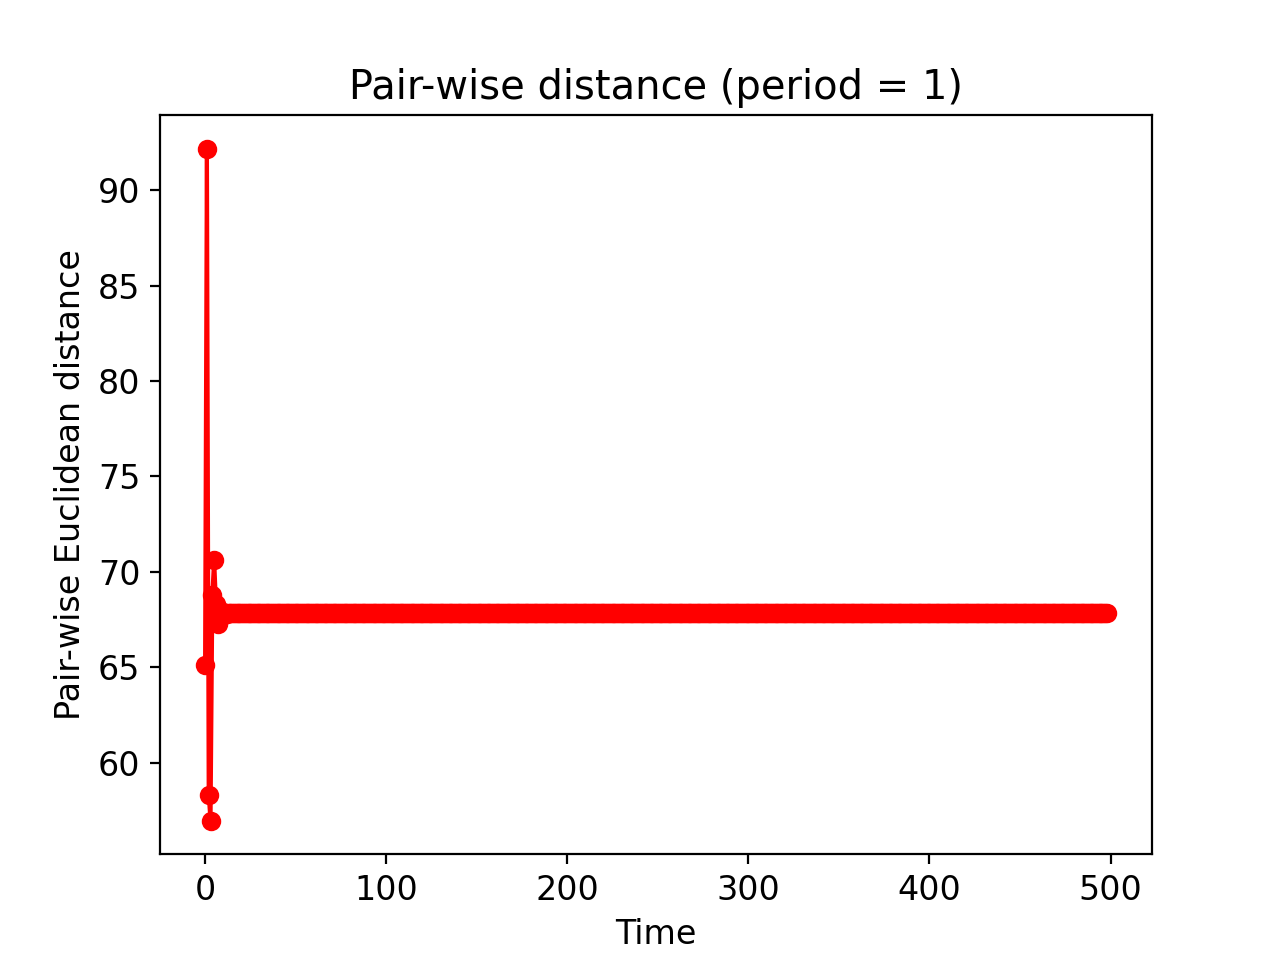

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


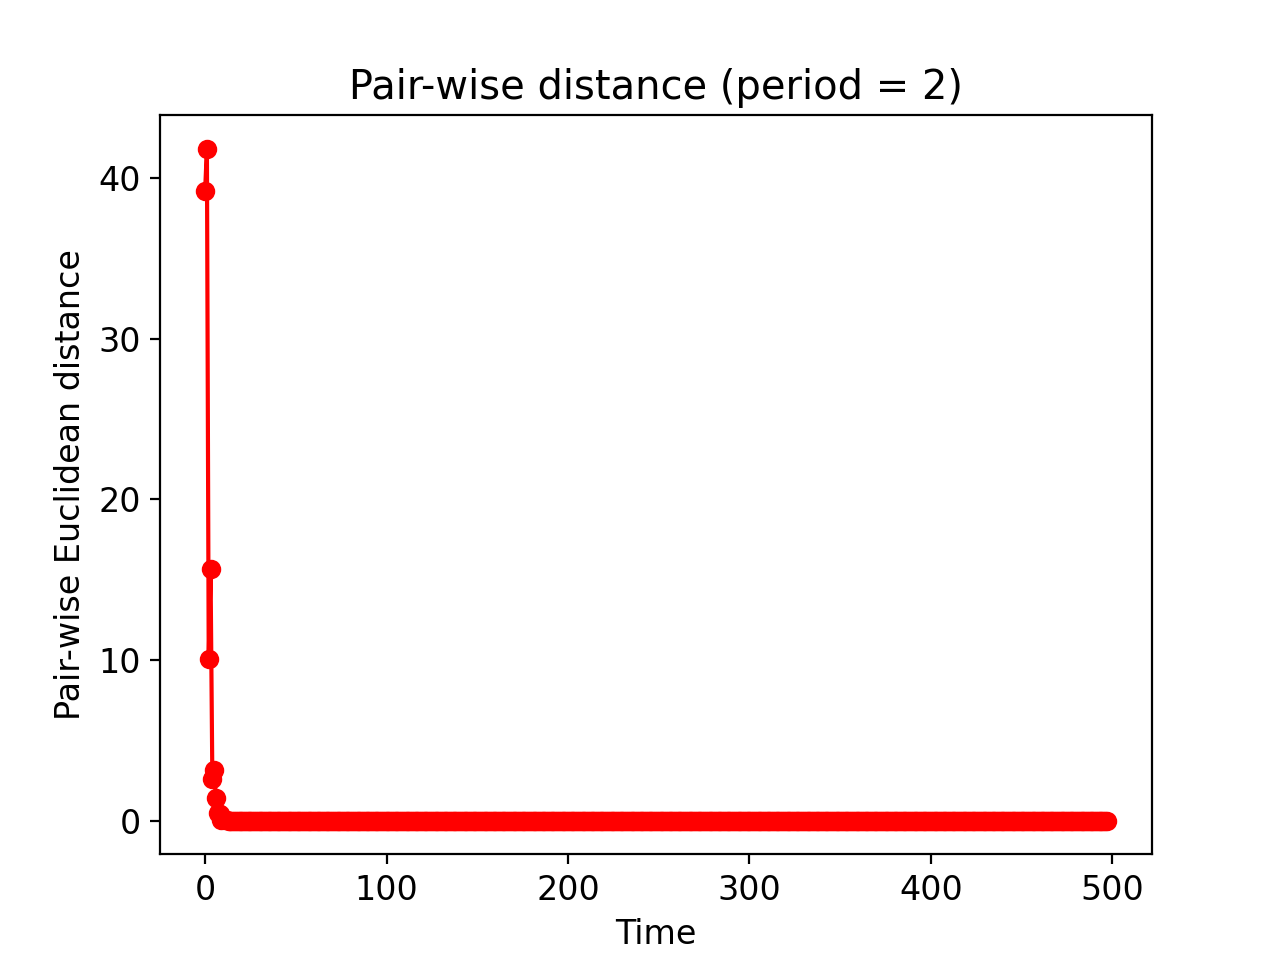

<IPython.core.display.Javascript object>


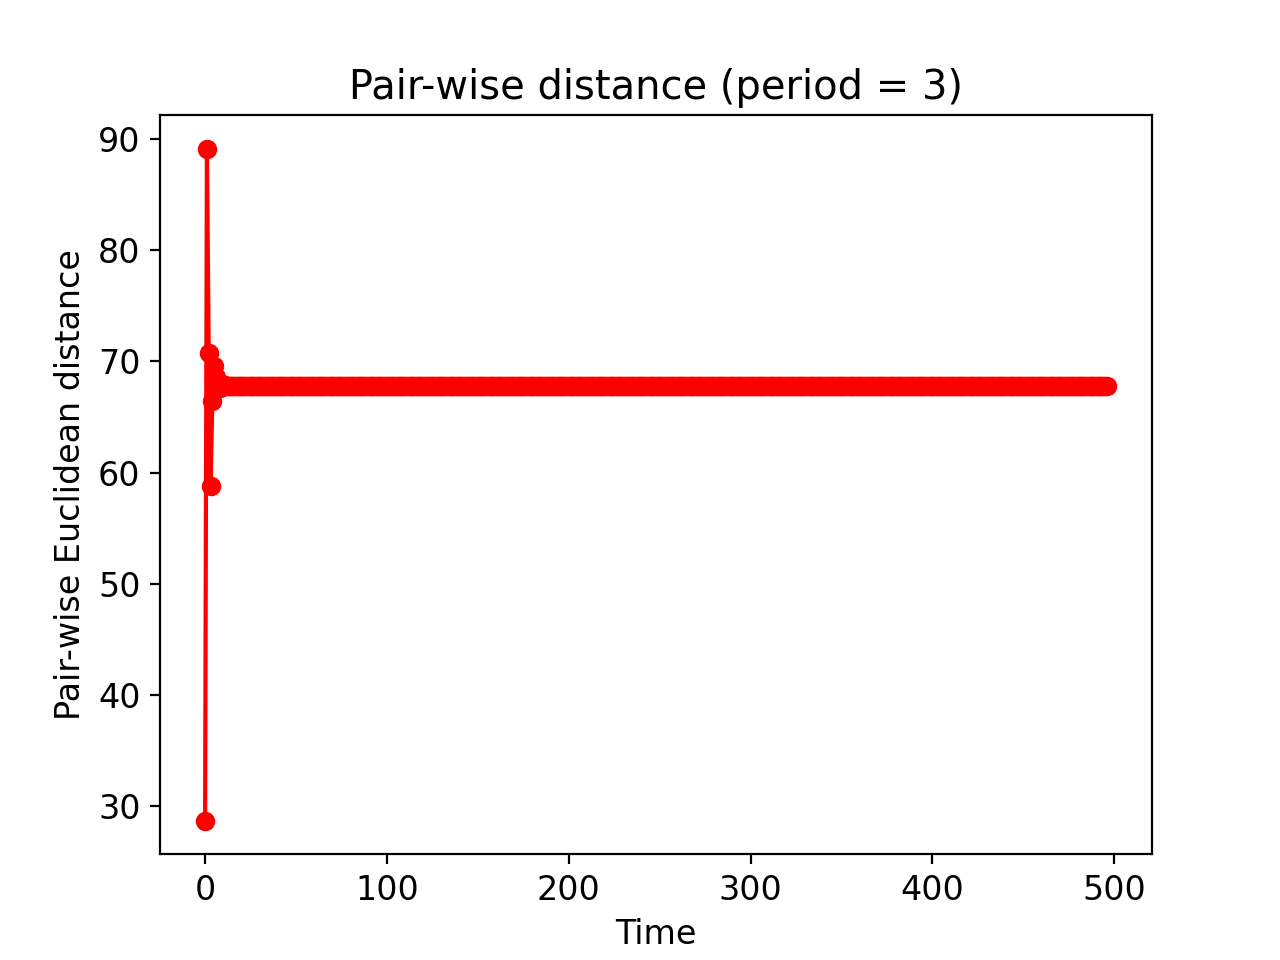

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


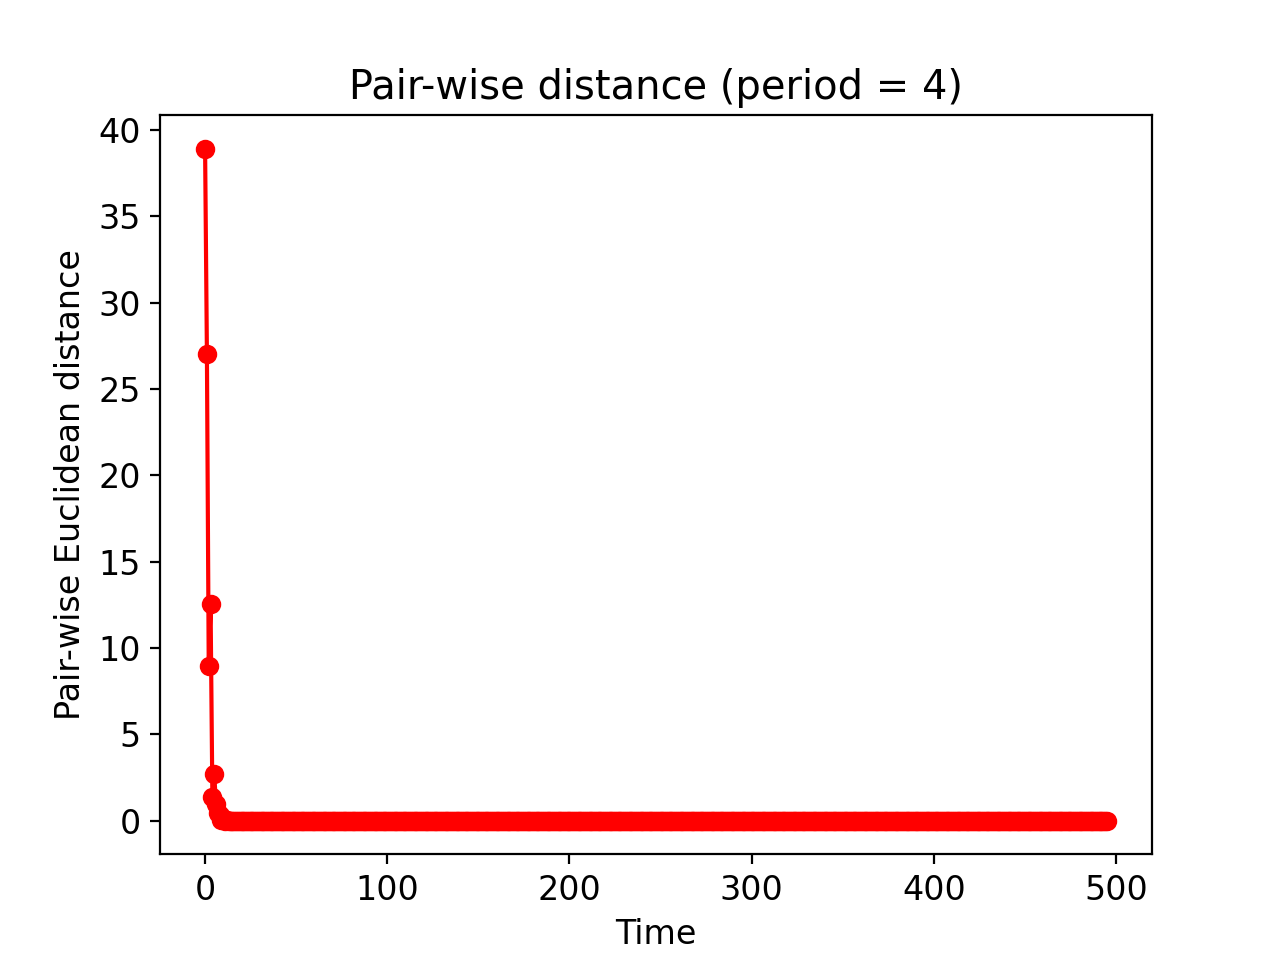

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


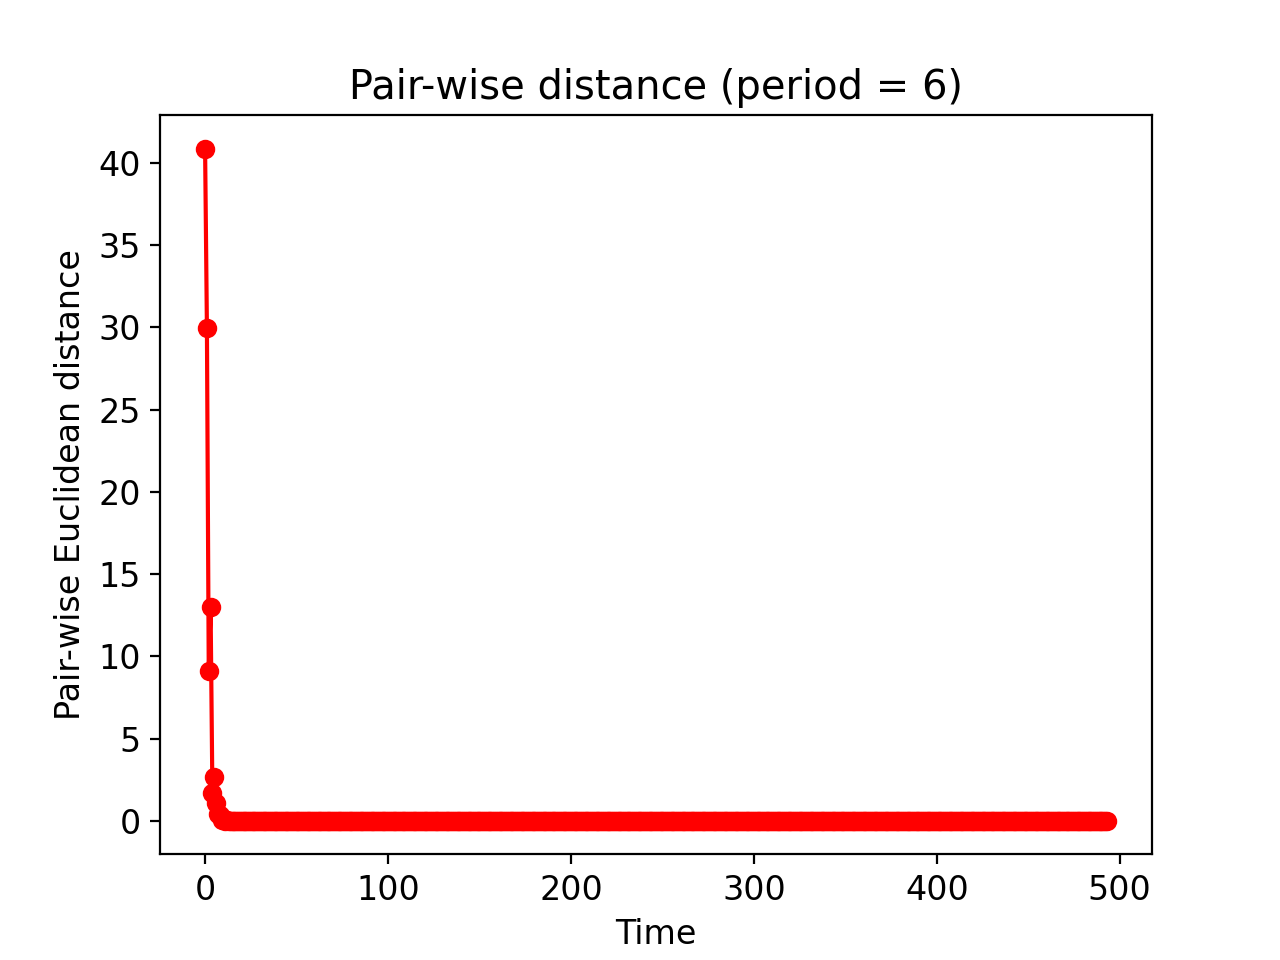

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


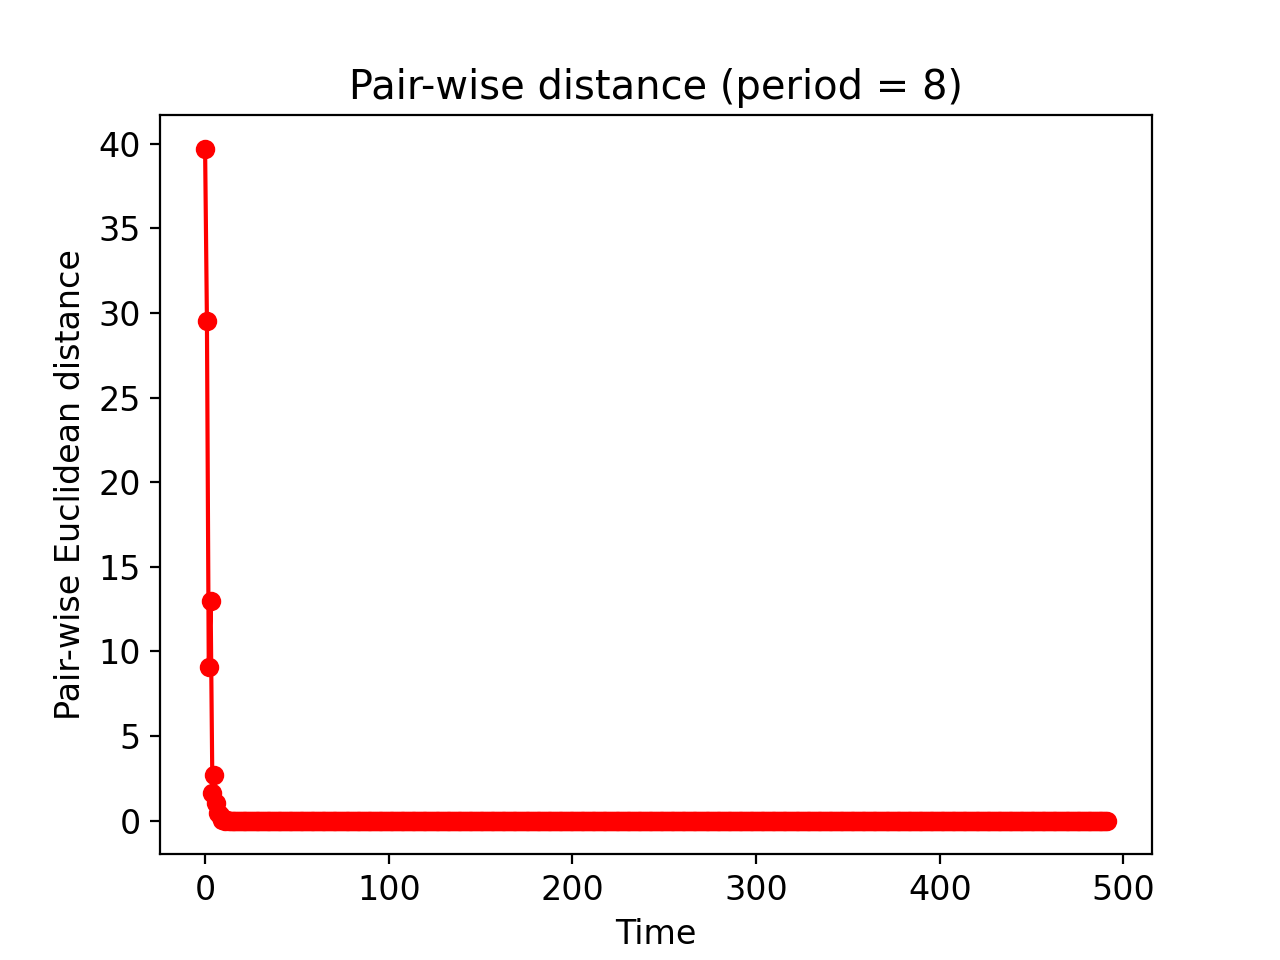

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


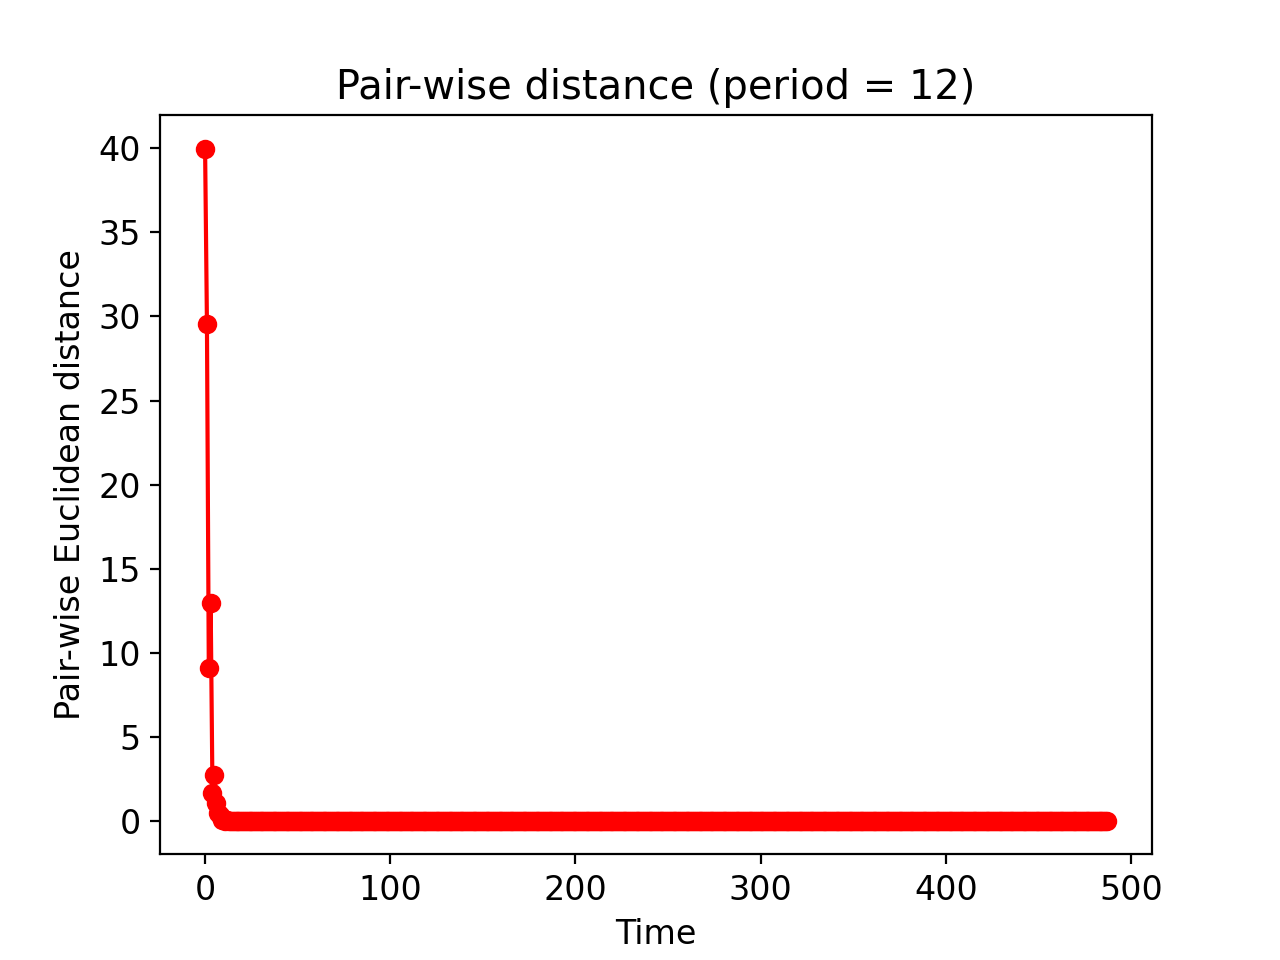

Does distance STAY below the threshold?: True


<IPython.core.display.Javascript object>


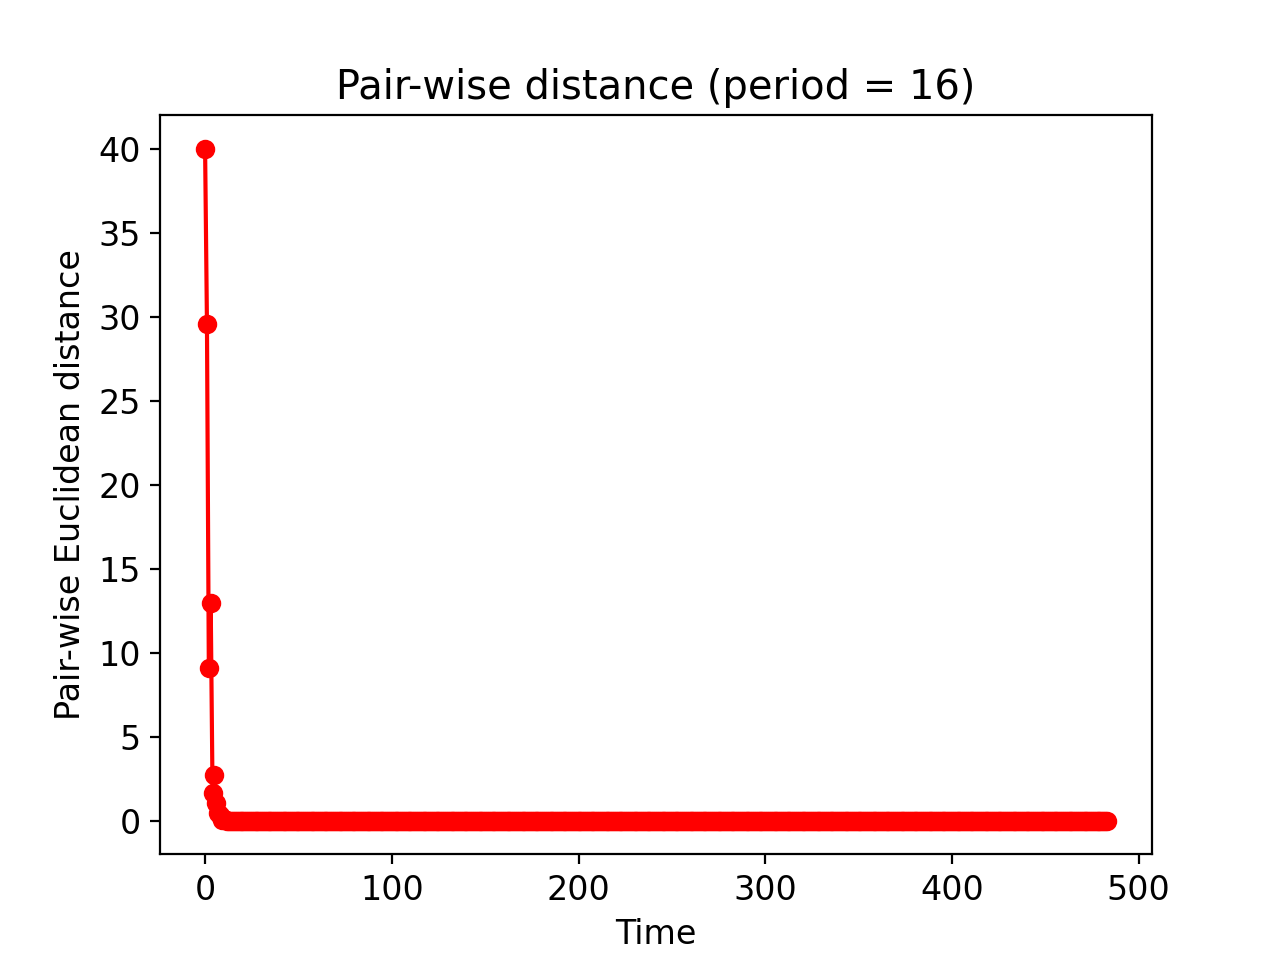

**************************************************
Is the dynamics Periodic? :True
**************************************************
The minimum period of the system is 2 times the forcing period
**************************************************


In [170]:
periodic_flag, min_period = filament.classify_filament_dynamics()

In [172]:
min_period

2